In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm.notebook import trange, tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [5]:
folder = os.path.join(data_dir,"dataset")

In [6]:
os.listdir(os.path.join(folder, "first_batch"))

['10x10_10mm_first_clean',
 '10x10_15mm_first_clean',
 '10x10_1mm_first_clean',
 '10x10_20mm_first_clean',
 '10x10_25mm_first_clean',
 '10x10_2mm_first_clean',
 '10x10_30mm_first_clean',
 '10x10_35mm_first_clean',
 '10x10_3mm_first_clean',
 '10x10_4mm_first_clean']

In [7]:
excluded = ['10x10_10mm_first_clean',
 '10x10_25mm_first_clean',
 '10x10_2mm_first_clean', '10x10_4mm_first_clean']

In [8]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter, splitter_train_val_test

In [9]:
from DataSets import UNetDataSetFromNpz, UNetDatasetFromFolders

In [10]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [11]:
model_name = "../model/trained_cUNet_regression_validation_50epochs_coeff_mask0.75_batch16_on_npz.pkl"

In [12]:
model_inference = cUNet(out_size=1)

In [13]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
composed = transforms.Compose([Cut(),Rescale(.25), ChannelsFirst(), ToTensor()])

In [16]:
test_dataset = UNetDatasetFromFolders(folder, excluded=excluded, transform=composed)

In [17]:
len(test_dataset)

7732

In [18]:
data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

In [19]:
model_inference.eval()
model_inference.to(device);

batch 1
1: true_dist: 30, pred_dist: [27.799665]


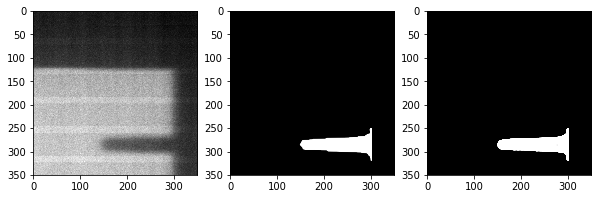

2: true_dist: 15, pred_dist: [15.49504]


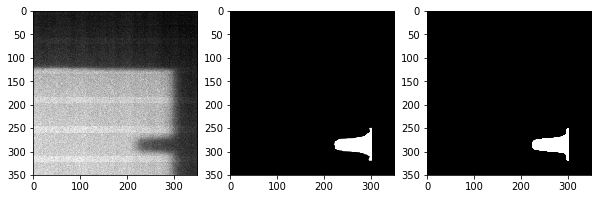

3: true_dist: 20, pred_dist: [20.462639]


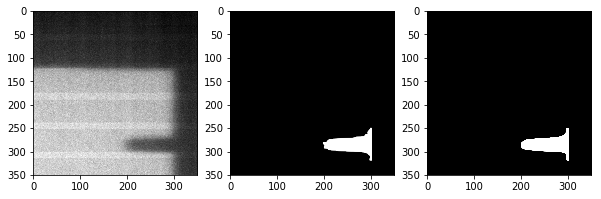

4: true_dist: 15, pred_dist: [15.457495]


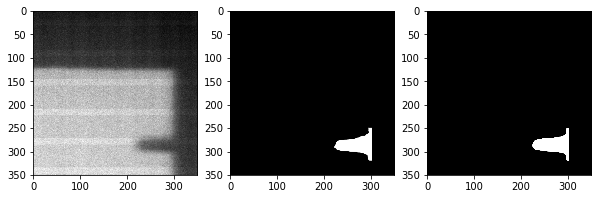

5: true_dist: 35, pred_dist: [29.623188]


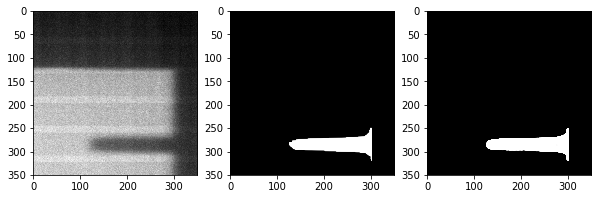

6: true_dist: 3, pred_dist: [2.8075714]


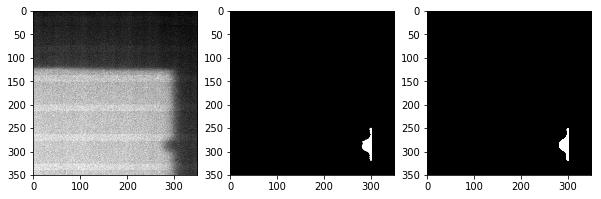

7: true_dist: 15, pred_dist: [15.301419]


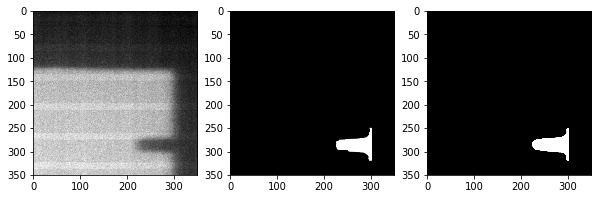

8: true_dist: 10, pred_dist: [10.019434]


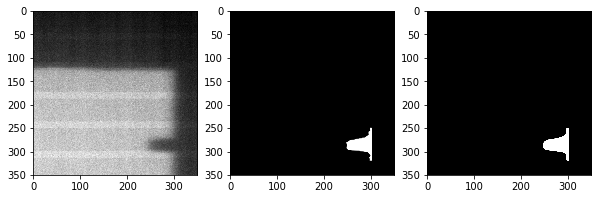

9: true_dist: 15, pred_dist: [15.21651]


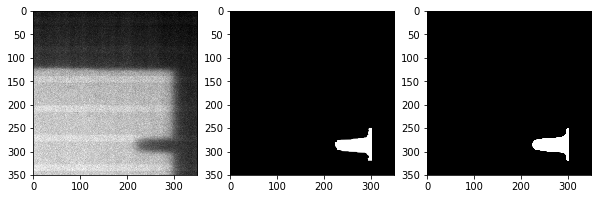

10: true_dist: 20, pred_dist: [20.661793]


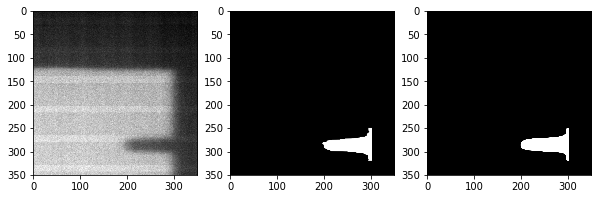

11: true_dist: 30, pred_dist: [27.734549]


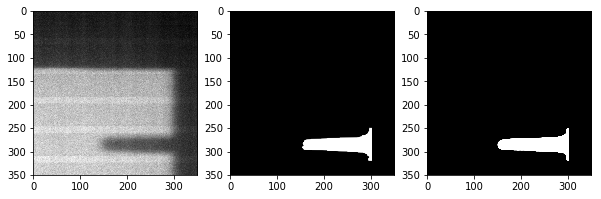

12: true_dist: 35, pred_dist: [29.2759]


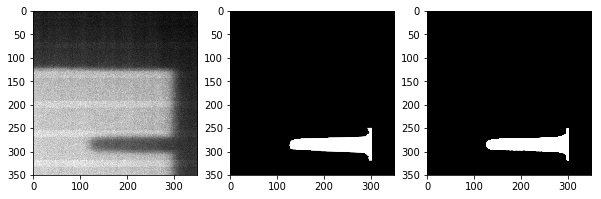

13: true_dist: 3, pred_dist: [2.9474268]


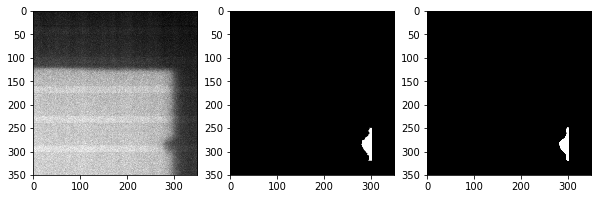

14: true_dist: 15, pred_dist: [15.424964]


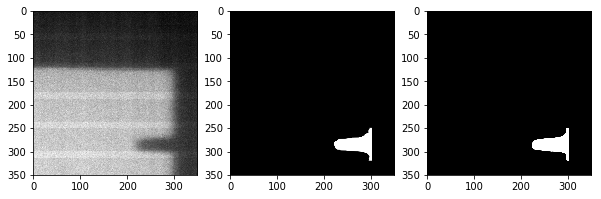

15: true_dist: 25, pred_dist: [24.752491]


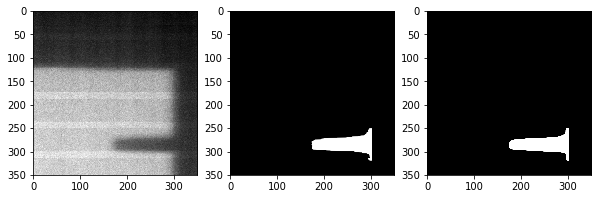

16: true_dist: 15, pred_dist: [15.593953]


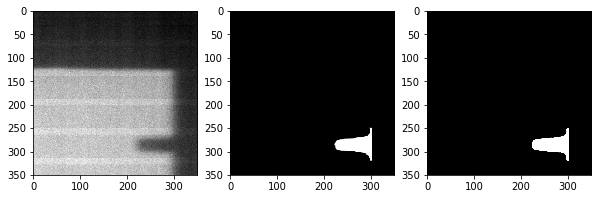

In [20]:
for i, batch in enumerate(data_loader):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_dist, pr_msk, pr_dist) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())):
    
        true_dist = tr_dist
        pred_dist = pr_dist
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    break

In [21]:
batch_size=16

In [22]:
y_true = []
y_pred = []

for i, batch in tqdm(enumerate(data_loader), total = len(test_dataset)//batch_size, desc = "Mini Batch"):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_dists.cpu().detach().numpy())):
        true_dist = tr_dist
        pred_dist = pr_dist
        y_true.append(true_dist)
        y_pred.append(pred_dist)


In [28]:
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred).ravel()
print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 4.313931923480767


In [29]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [30]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [31]:
distances = [1,2,3,4,10,15,20,25,30,35]

In [32]:
errors = [idx_mse(i)[1] for i in distances]

1 0.24235138049223132
2 0.013670774777158789
3 0.0530128177636608
4 0.016859874870366696
10 0.07876675832976161
15 0.1727079761139339
20 0.37516064459066306
25 0.03669064371362765
30 5.297429456623269
35 30.827486249912546


np.savez_compressed(os.path.join(data_dir, "Predicted_2_4_10_25_ALL_out_model_trained_on_npz.npz"),
                   true = y_true, pred = y_pred)

In [ ]:
np.savez_compressed(os.path.join(data_dir, "Predicted_ALL_DATA_model_trained_on_npz.npz"), true = y_true, pred = y_pred)